In [1]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
This file is used to calculate Hessian information for a model during training for the nested N-spheres task, with cross entropy loss.
The analysis of these results is executed using the file nested_spheres_hessian_analysis.ipynb.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [2]:
%%capture
%%bash 
pip install torchdiffeq

In [64]:
import os
import argparse
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False)
parser.add_argument('--visualise', type=eval, default=True)
parser.add_argument('--niters', type=int, default=600)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--extra_dim', type=int, default=0)
parser.add_argument('--data_dimension', type=int, default=2)
parser.add_argument('--npoints', type=int, default=50)
parser.add_argument('--ntest', type=int, default=10)
parser.add_argument('--hessian_freq', type=int, default=20)
parser.add_argument('--library_hessian', type=eval, default = False)
parser.add_argument('--manual_hessian', type=eval, default = False)
parser.add_argument('--mofd_hessian', type=eval, default = False)
args = parser.parse_args(args=[])

args.hessian_freq = 5
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [5]:
class ODEfunc(nn.Module):
    """
    Neural network to parametrise the derivative of the state vector. Maps from [dim] to [dim] dimensions.
    """
    def __init__(self, dim, nhidden):
        super(ODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out
    

class ODEBlock(nn.Module):
    """
    Defines the entire ODE block that acts on the state vector, i.e. it perfoms integration on the state vector
    with the derivative given by an ODEFunc() object, and interval given by [t0, tN].
    """
    def __init__(self, odefunc, t0_, tN_):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_times = torch.tensor([t0_, tN_]).float()
        
    def forward(self, x):
        out = odeint(self.odefunc, x, self.integration_times, rtol=args.tol, atol=args.tol)
        out = out[1]
        return out

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

In [6]:
class Decoder(nn.Module):
    """
    Function that maps 2D output to another vector. 
    """
    def __init__(self, in_dim, out_dim):          #out_dim = 2.
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, z):
        out = self.fc(z)
        return out

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Hessian calculation techniques. These are designed to work with any data dimension and augmentation.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [8]:
class Network(nn.Module):
  """
  Neural network that is used for Hessian calculation with library-function and MOFD approaches.
  """

  def __init__(self, a, b, c, d, e, f):
    super(Network, self).__init__()
    self.a = a
    self.b = b
    self.c = c
    self.d = d
    self.e = e
    self.f = f

  def forward(self, t, y):
    m = nn.ELU(inplace=True)
    x = F.linear(y, self.a, self.b)
    x = m(x)
    x = F.linear(x, self.c, self.d)
    x = m(x)
    x = F.linear(x, self.e, self.f)

    return x

In [9]:
class Integrator(nn.Module):
  """
  ODE block that is used to calculate the Hessian via the library and MOFD approaches.
  """
  def __init__(self, g, h, odefunc, t0, tN):
    super(Integrator, self).__init__()
    self.g = g
    self.h = h
    self.odefunc = odefunc
    self.integration_times = torch.tensor([t0, tN]).float()

  def forward(self, y):
    x = odeint(self.odefunc, y, self.integration_times, rtol=args.tol, atol=args.tol)
    x = x[1]
    x = F.linear(x, self.g, self.h)
    return x

In [10]:
def get_loss(params_vector):

  a = params_vector[:nhidden*dim].reshape([nhidden, dim])
  b = params_vector[nhidden*dim:nhidden*(dim+1)].reshape([nhidden])
  c = params_vector[nhidden*(dim+1):nhidden*(dim+1)+nhidden**2].reshape([nhidden, nhidden])
  d = params_vector[nhidden*(dim+1)+nhidden**2:nhidden*(dim+2)+nhidden**2].reshape([nhidden])
  e = params_vector[nhidden*(dim+2)+nhidden**2:nhidden*(2*dim+2)+nhidden**2].reshape([dim,nhidden])
  f = params_vector[nhidden*(2*dim+2)+nhidden**2:nhidden*(2*dim+2)+nhidden**2+dim].reshape([dim])
  g = params_vector[nhidden*(2*dim+2)+nhidden**2+dim:nhidden*(2*dim+2)+nhidden**2+3*dim].reshape([2,dim])
  h = params_vector[nhidden*(2*dim+2)+nhidden**2+3*dim:nhidden*(2*dim+2)+nhidden**2+3*dim+2].reshape([2])
  
  neural_net = Network(a, b, c, d, e, f).to(device)
  full_block = Integrator(g, h, neural_net, t0, tN)
  pred_z = full_block(z0)
  loss_func = nn.CrossEntropyLoss()

  target = torch.zeros(len(zN))
  for i in range(len(zN)):
    if zN[i]==0:
      target[i] = 0
    else:
      target[i] = 1
  target = target.long()

  loss = loss_func(pred_z, target)
  return loss

def get_library_hessian(net):
  """
  Obtains the Hessian of the NODE using the autograd.functional.hessian() function.
  Inputs: 
        - net: the network for which the Hessian is to be calculated.
  NB: Each individual NODE architecture must be specified in the function get_loss(), such that
  the Hessian is calculated correctly.
  """

  param_tensors = net.parameters()
  params_vector = torch.tensor([]).to(device)
  for param in param_tensors:
    vec = torch.reshape(param, (-1,)).to(device)
    params_vector = torch.cat((params_vector, vec))
  hessian = torch.autograd.functional.hessian(get_loss, params_vector)
  return hessian

In [11]:
def get_manual_hessian(grads, parameters, show_iters=True):
  """
  Calculation of the Hessian using nested for loops.
  Inputs:   - grads:        tuple of gradient tensors. Created using something 
                            like grads = torch.autograd.grad(loss, parameters, create_graph=True).
            - parameters:   List of parameter objects. Created using something 
                            like parameters = optimizer.param_groups[0]['params'].
            - show_iters:   True or False, depending on if the iteration number is to be shown during training. 
                            Note that the iteration updates are not provided every row, but instead periodically 
                            (roughly according to the number of parameters in the system).
  """
  start = time.time()        

  n_params = 0
  for param in parameters:
    n_params += torch.numel(param)
  grads2 = torch.zeros(n_params,n_params)            #Create an matrix of zeros thas has the same shape as the Hessian.

  y_counter = 0                             #y_direction refers to row number in the Hessian.

  for grad in grads:
      grad = torch.reshape(grad, [-1])                                  #Rearrange the gradient information into a vector.        

      for j, g in enumerate(grad):
        x_counter = 0                                                   #x_direction refers to column number in the Hessian.

        for l, param in enumerate(parameters):
          g2 = torch.autograd.grad(g, param, retain_graph=True)[0]      #Calculate the gradient of an element of the gradient wrt one layer's parameters.
          g2 = torch.reshape(g2, [-1])                                  #Reshape this into a vector.
          len = g2.shape[0]                       
          grads2[j+y_counter, x_counter:x_counter+len] = g2             #Indexing ensures that the second order derivatives are placed in the correct positions.
          x_counter += len

      grads2 = grads2.to(device)
      y_counter += grad.shape[0]

      if show_iters:
        print("Gradients calculated for row number " + str(y_counter) + ".")
  
  print('Time used was ', time.time() - start)

  return grads2

In [12]:
def get_mofd_hessian_element(p_vec, shapes, base_loss, i, k, h=1e-4):
  """
  Calculates an individual element of the Hessian via the MOFD.
  Inputs: - p_vec:        the parameters of the network organized into a vector.
          - shapes:       a list of torch.Size() objects describing the shapes of each parameter group.
          - base_loss:    loss of the unperturbed system. Used in calculating diagonal Hessian elements.
          - h:            the size of the pertubation applied to each parameter.
          - i and k:      the indices of the element to be calculated.
          - show_iters:   True or False according to whether iteration number is to be displayed during calculation.

  Returns: - 'grad2':     torch.tensor() object containing the Hessian element H[i,k] = H[k,i].
  
  NB: This function adapts to network architecture automatically.
  The code is designed to convert all floats to 64-bit automatically.
  """
  loss_func = nn.CrossEntropyLoss()

  target = torch.zeros(len(zN))
  for m in range(len(zN)):
    if zN[m]==0:
      target[m] = 0
    else:
      target[m] = 1
  target = target.long()

  #List of integers detailing the number of elements in each parameter group.
  nels = [int(torch.prod(torch.tensor(shape))) for shape in shapes]
  nels = torch.tensor(nels)
  nels = torch.cumsum(nels, dim=0)
  nels = nels.tolist()

  #Empty tensors to store mofd info and perturbed parameters.
  up_pert_p_vec = torch.zeros_like(p_vec).double()
  low_pert_p_vec = torch.zeros_like(p_vec).double()

  up_up_pert_p_vec = torch.zeros_like(p_vec).double()
  up_low_pert_p_vec = torch.zeros_like(p_vec).double()
  low_up_pert_p_vec = torch.zeros_like(p_vec).double()
  low_low_pert_p_vec = torch.zeros_like(p_vec).double()
    
  #Versions of the parameter vector to be perturbed.
  for j in range(len(p_vec)):
    up_pert_p_vec[j] = p_vec[j]
    low_pert_p_vec[j] = p_vec[j]
    
  #Calculate the diagonal elements.
  if k == i:
    up_pert_p_vec[k] += h
    low_pert_p_vec[k] -= h

    a_up = up_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_up = up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_up = up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_up = up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])
    e_up = up_pert_p_vec[nels[3]:nels[4]].reshape(shapes[4])
    f_up = up_pert_p_vec[nels[4]:nels[5]].reshape(shapes[5])
    g_up = up_pert_p_vec[nels[5]:nels[6]].reshape(shapes[6])
    h_up = up_pert_p_vec[nels[6]:nels[7]].reshape(shapes[7])

    a_low = low_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_low = low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_low = low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_low = low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])
    e_low = low_pert_p_vec[nels[3]:nels[4]].reshape(shapes[4])
    f_low = low_pert_p_vec[nels[4]:nels[5]].reshape(shapes[5])
    g_low = low_pert_p_vec[nels[5]:nels[6]].reshape(shapes[6])
    h_low = low_pert_p_vec[nels[6]:nels[7]].reshape(shapes[7])

    neural_net_up = Network(a_up, b_up, c_up, d_up, e_up, f_up).to(device)
    full_block = Integrator(g_up, h_up, neural_net_up, t0, tN)
    pred_z = full_block(z0.double())
    pert_loss_up = loss_func(pred_z, target)

    neural_net_low = Network(a_low, b_low, c_low, d_low, e_low, f_low).to(device)
    full_block = Integrator(g_low, h_low, neural_net_low, t0, tN)
    pred_z = full_block(z0.double())
    pert_loss_low = loss_func(pred_z, target)
    
    grad2 = ((pert_loss_up - 2*base_loss + pert_loss_low)/(h**2)).double()

  #Calculate the off-diagonal elements.
  if k > i:
    
    #Vectors to be perturbed (there are 4 of these).
    #They must be created individually for each k so that previous iterations do not affect the parameter values.
    for l in range(len(p_vec)):
      up_up_pert_p_vec[l] = p_vec[l]
      up_low_pert_p_vec[l] = p_vec[l]
      low_up_pert_p_vec[l] = p_vec[l]
      low_low_pert_p_vec[l] = p_vec[l]

    up_up_pert_p_vec[i] += h
    up_up_pert_p_vec[k] += h

    up_low_pert_p_vec[i] += h
    up_low_pert_p_vec[k] -= h

    low_up_pert_p_vec[i] -= h
    low_up_pert_p_vec[k] += h

    low_low_pert_p_vec[i] -= h
    low_low_pert_p_vec[k] -= h

    a_up_up = up_up_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_up_up = up_up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_up_up = up_up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_up_up = up_up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])
    e_up_up = up_up_pert_p_vec[nels[3]:nels[4]].reshape(shapes[4])
    f_up_up = up_up_pert_p_vec[nels[4]:nels[5]].reshape(shapes[5])
    g_up_up = up_up_pert_p_vec[nels[5]:nels[6]].reshape(shapes[6])
    h_up_up = up_up_pert_p_vec[nels[6]:nels[7]].reshape(shapes[7])

    a_up_low = up_low_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_up_low = up_low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_up_low = up_low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_up_low = up_low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])
    e_up_low = up_low_pert_p_vec[nels[3]:nels[4]].reshape(shapes[4])
    f_up_low = up_low_pert_p_vec[nels[4]:nels[5]].reshape(shapes[5])
    g_up_low = up_low_pert_p_vec[nels[5]:nels[6]].reshape(shapes[6])
    h_up_low = up_low_pert_p_vec[nels[6]:nels[7]].reshape(shapes[7])

    a_low_up = low_up_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_low_up = low_up_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_low_up = low_up_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_low_up = low_up_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])
    e_low_up = low_up_pert_p_vec[nels[3]:nels[4]].reshape(shapes[4])
    f_low_up = low_up_pert_p_vec[nels[4]:nels[5]].reshape(shapes[5])
    g_low_up = low_up_pert_p_vec[nels[5]:nels[6]].reshape(shapes[6])
    h_low_up = low_up_pert_p_vec[nels[6]:nels[7]].reshape(shapes[7])

    a_low_low = low_low_pert_p_vec[:nels[0]].reshape(shapes[0])
    b_low_low = low_low_pert_p_vec[nels[0]:nels[1]].reshape(shapes[1])
    c_low_low = low_low_pert_p_vec[nels[1]:nels[2]].reshape(shapes[2])
    d_low_low = low_low_pert_p_vec[nels[2]:nels[3]].reshape(shapes[3])
    e_low_low = low_low_pert_p_vec[nels[3]:nels[4]].reshape(shapes[4])
    f_low_low = low_low_pert_p_vec[nels[4]:nels[5]].reshape(shapes[5])
    g_low_low = low_low_pert_p_vec[nels[5]:nels[6]].reshape(shapes[6])
    h_low_low = low_low_pert_p_vec[nels[6]:nels[7]].reshape(shapes[7])

    neural_net_up_up = Network(a_up_up, b_up_up, c_up_up, d_up_up, e_up_up, f_up_up).to(device)
    full_block = Integrator(g_up_up, h_up_up, neural_net_up_up, t0, tN)
    pred_z = full_block(z0.double())
    pert_loss_up_up = loss_func(pred_z, target)

    neural_net_up_low = Network(a_up_low, b_up_low, c_up_low, d_up_low, e_up_low, f_up_low).to(device)
    full_block = Integrator(g_up_low, h_up_low, neural_net_up_low, t0, tN)
    pred_z = full_block(z0.double())
    pert_loss_up_low = loss_func(pred_z, target)

    neural_net_low_up = Network(a_low_up, b_low_up, c_low_up, d_low_up, e_low_up, f_low_up).to(device)
    full_block = Integrator(g_low_up, h_low_up, neural_net_low_up, t0, tN)
    pred_z = full_block(z0.double())
    pert_loss_low_up = loss_func(pred_z, target)

    neural_net_low_low = Network(a_low_low, b_low_low, c_low_low, d_low_low, e_low_low, f_low_low).to(device)
    full_block = Integrator(g_low_low, h_low_low, neural_net_low_low, t0, tN)
    pred_z = full_block(z0.double())
    pert_loss_low_low = loss_func(pred_z, target)
    
    #MOFD formula to estimate second order gradient.
    grad2 = ((pert_loss_up_up - pert_loss_up_low - pert_loss_low_up + pert_loss_low_low)/(4*h**2)).double()

  return grad2

In [13]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Hessian calculation execution.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [98]:
def get_random_indices(max, num):
  """
  Produces two lists of random numbers.
  Inputs:   - max: The maximum index to be produced.
            - num: The length of the lists to be produced.

  random_k[j] > random_i[j] for all j. Failing to do so yields UnboundLocalError since local variable, grad2, is referenced before assignment.
  """
  random_i = random.sample(range(0, max), num)
  random_k = []

  for k in range(num):
    randint = np.random.randint(0,max)
    while randint < random_i[k]:
      randint =  np.random.randint(0,max)
    random_k.append(randint)

  return random_i, random_k

In [99]:
#Download data
args.extra_dim = 0
exp_name = 'experiment_0'
name_in = str(args.data_dimension)+'din_'+str(args.npoints)+'_train.npy'        #Only use the training data.
name_out = str(args.data_dimension)+'dout_'+str(args.npoints)+'_train.npy'
folder_name = '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/data/'
z0 = torch.tensor(np.load(folder_name+name_in)).float().to(device)
zN = torch.tensor(np.load(folder_name+name_out)).float().to(device)

#Augment z0
zeros = torch.zeros(args.npoints, args.extra_dim).float()
z0 = torch.cat((z0, zeros), dim=1).to(device)

dim = args.data_dimension + args.extra_dim
t0, tN = 0.0, 1.0
nhidden = 20

#This code generates a model. Can be used instead of loading a pre-trained version.
#feature_layers = [ODEBlock(ODEfunc(dim, nhidden), t0, tN), Decoder(dim, 2)]
#net = nn.Sequential(*feature_layers).to(device)

In [126]:
#Get manual and library Hessians for an individual iteration.

itr = 540      #Iteration to examine.
print('Iteration: ' + str(itr))

if args.extra_dim == 0:
  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/node/models/model_'
                  + str(itr) + '.pt')
else:
  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/anode('
                    +str(args.extra_dim)+')/models/model_'+ str(itr) + '.pt')

#Get manual Hessian.
optimizer = optim.Adam(model.parameters())
optimizer.zero_grad()

pred_y = model(z0)
base_loss_func = nn.CrossEntropyLoss()

target = torch.zeros(len(zN))
for i in range(len(zN)):
  if zN[i]==0:
    target[i] = 0
  else:
    target[i] = 1
target = target.long()

base_loss = base_loss_func(pred_y, target)
grads = torch.autograd.grad(base_loss, model.parameters(), create_graph=True)
parameters = optimizer.param_groups[0]['params']

print('Obtaining manual hessian...')
manual_hessian = get_manual_hessian(grads, parameters)           #get manual hessian.

#Get library hessian.
print('Obtaining library hessian...')
library_hessian = get_library_hessian(model)

Iteration: 540
Obtaining manual hessian...
Gradients calculated for row number 40.
Gradients calculated for row number 60.
Gradients calculated for row number 460.
Gradients calculated for row number 480.
Gradients calculated for row number 520.
Gradients calculated for row number 522.
Gradients calculated for row number 526.
Gradients calculated for row number 528.
Time used was  85.03781962394714
Obtaining library hessian...


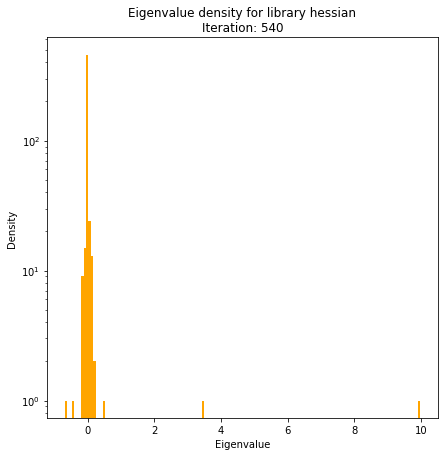

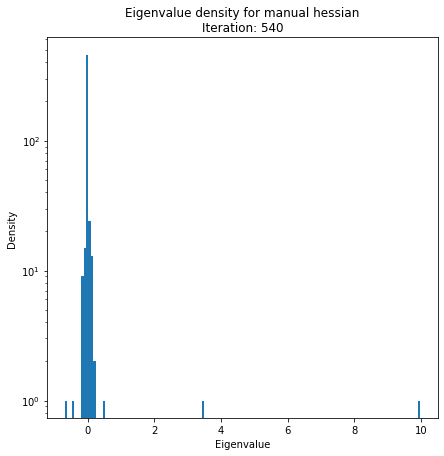

In [127]:
#Create eigenvalue density plots for an individual iteration.
try:
  e, v = torch.symeig(library_hessian)
  plt.figure(figsize=[7,7])
  plt.hist(e[:-1], bins=150, color='Orange')
  plt.xlabel('Eigenvalue')
  plt.ylabel('Density')
  plt.title('Eigenvalue density for library hessian\nIteration: ' + str(itr))
  plt.yscale('log')
  plt.show()

except NameError:
  pass
  
try:
  e, v = torch.symeig(manual_hessian)
  plt.figure(figsize=[7,7])
  plt.hist(e[:-1], bins=150)
  plt.xlabel('Eigenvalue')
  plt.ylabel('Density')
  plt.title('Eigenvalue density for manual hessian\nIteration: ' + str(itr))
  plt.yscale('log')
  plt.show()

except NameError:
  pass

In [129]:
#The code in this cell is used to calculate a random selection of elements with the MOFD for a range of pertubation parameters.
#This can then be used in comparison with library approach.

max, num = library_hessian.shape[0], 300
random_i, random_k = get_random_indices(max, num)

#MOFD Hessian for various h.
if args.extra_dim == 0:
  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/node/models/model_'
                  + str(itr) + '.pt')
else:
  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/anode('
                    +str(args.extra_dim)+')/models/model_'+ str(itr) + '.pt')
  
double_model = model.double()
optimizer = optim.Adam(model.parameters())
optimizer.zero_grad()

#Prepare loss for MOFD.
pred_y = model(z0.double()).double()
base_loss_func = nn.CrossEntropyLoss()
target = torch.zeros(len(zN))
for i in range(len(zN)):
  if zN[i]==0:
    target[i] = 0
  else:
    target[i] = 1
target = target.long()
base_loss = base_loss_func(pred_y, target).double()

#Prepare shape information for MOFD.
shapes = []
for param in model.parameters():
  shapes.append(param.shape)

#Create vector of parameters.
param_tensors = double_model.parameters()
params_vec = torch.tensor([]).to(device)
for param in param_tensors:
  vec = torch.reshape(param, (-1,)).to(device)
  params_vec = torch.cat((params_vec, vec))

w = len(params_vec)                 
print('Getting MOFD Hessian with h = 1e-2 for iteration ' + str(itr) + '...')
mofd_hessian_2 = torch.zeros((w,w)).double()
counter = num
for j in range(num):
  i = random_i[j]
  k = random_k[j]
                   
  element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-2)
  mofd_hessian_2[i,k] = element.item()
  mofd_hessian_2[k,i] = element.item()
  counter -= 1
  print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

w = len(params_vec)                 
print('Getting MOFD Hessian with h = 1e-3 for iteration ' + str(itr) + '...')
mofd_hessian_3 = torch.zeros((w,w)).double()
counter = num
for j in range(num):
  i = random_i[j]
  k = random_k[j]

  element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-3)
  mofd_hessian_3[i,k] = element.item() 
  mofd_hessian_3[k,i] = element.item()
  counter -= 1
  print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

w = len(params_vec)                 
print('Getting MOFD Hessian with h = 1e-4 for iteration ' + str(itr) + '...')
mofd_hessian_4 = torch.zeros((w,w)).double()
counter = num
for j in range(num):
  i = random_i[j]
  k = random_k[j]
                
  element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-4)
  mofd_hessian_4[i,k] = element.item() 
  mofd_hessian_4[k,i] = element.item()
  counter -= 1
  print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

w = len(params_vec)                 
print('Getting MOFD Hessian with h = 1e-5 for iteration ' + str(itr) + '...')
mofd_hessian_5 = torch.zeros((w,w)).double()
counter = num
for j in range(num):
  i = random_i[j]
  k = random_k[j]          

  element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-5)
  mofd_hessian_5[i,k] = element.item()   
  mofd_hessian_5[k,i] = element.item()
  counter -= 1
  print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

w = len(params_vec)                 
print('Getting MOFD Hessian with h = 1e-6 for iteration ' + str(itr) + '...')
mofd_hessian_6 = torch.zeros((w,w)).double()
counter = num
for j in range(num):
  i = random_i[j]
  k = random_k[j]

  element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-6)
  mofd_hessian_6[i,k] = element.item()  
  mofd_hessian_6[k,i] = element.item()
  counter -= 1
  print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

w = len(params_vec)                 
print('Getting MOFD Hessian with h = 1e-7 for iteration ' + str(itr) + '...')
mofd_hessian_7 = torch.zeros((w,w)).double()
counter = num
for j in range(num):
  i = random_i[j]
  k = random_k[j]

  element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-7)
  mofd_hessian_7[i,k] = element.item()   
  mofd_hessian_7[k,i] = element.item()
  counter -= 1
  print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

w = len(params_vec)                 
print('Getting MOFD Hessian with h = 1e-8 for iteration ' + str(itr) + '...')
mofd_hessian_8 = torch.zeros((w,w)).double()
counter = num
for j in range(num):
  i = random_i[j]
  k = random_k[j]

  element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-8)
  mofd_hessian_8[i,k] = element.item()   
  mofd_hessian_8[k,i] = element.item()
  counter -= 1
  print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

Getting MOFD Hessian with h = 1e-2 for iteration 540...
Iterations remaining: 0, Element: -1.6990249579029777
Getting MOFD Hessian with h = 1e-3 for iteration 540...
Iterations remaining: 0, Element: -2.9739020657899853
Getting MOFD Hessian with h = 1e-4 for iteration 540...
Iterations remaining: 0, Element: -3.33552604023994
Getting MOFD Hessian with h = 1e-5 for iteration 540...
Iterations remaining: 0, Element: -3.4568515183599344
Getting MOFD Hessian with h = 1e-6 for iteration 540...
Iterations remaining: 0, Element: -3.4567416203751256
Getting MOFD Hessian with h = 1e-7 for iteration 540...
Iterations remaining: 0, Element: -3.4574339918824752
Getting MOFD Hessian with h = 1e-8 for iteration 540...
Iterations remaining: 0, Element: -3.395992254767721


In [130]:
#Calculate summed difference between 2 Hessians.

difference_2 = 0
differences_2 = []
for j in range(num):
  i = random_i[j]
  k = random_k[j]
  difference_2 += torch.abs(mofd_hessian_2[i,k]-library_hessian[i,k]).item()
  differences_2.append((torch.abs(mofd_hessian_2[i,k]-library_hessian[i,k]).item()))

difference_3 = 0
differences_3 = []
for j in range(num):
  i = random_i[j]
  k = random_k[j]
  difference_3 += torch.abs(mofd_hessian_3[i,k]-library_hessian[i,k]).item()
  differences_3.append((torch.abs(mofd_hessian_3[i,k]-library_hessian[i,k]).item()))

difference_4 = 0
differences_4 = []
for j in range(num):
  i = random_i[j]
  k = random_k[j]
  difference_4 += torch.abs(mofd_hessian_4[i,k]-library_hessian[i,k]).item()
  differences_4.append((torch.abs(mofd_hessian_4[i,k]-library_hessian[i,k]).item()))

difference_5 = 0
differences_5 = []
for j in range(num):
  i = random_i[j]
  k = random_k[j]
  difference_5 += torch.abs(mofd_hessian_5[i,k]-library_hessian[i,k]).item()
  differences_5.append((torch.abs(mofd_hessian_5[i,k]-library_hessian[i,k]).item()))

difference_6 = 0
differences_6 = []
for j in range(num):
  i = random_i[j]
  k = random_k[j]
  difference_6 += torch.abs(mofd_hessian_6[i,k]-library_hessian[i,k]).item()
  differences_6.append((torch.abs(mofd_hessian_6[i,k]-library_hessian[i,k]).item()))

difference_7 = 0
differences_7 = []
for j in range(num):
  i = random_i[j]
  k = random_k[j]
  difference_7 += torch.abs(mofd_hessian_7[i,k]-library_hessian[i,k]).item()
  differences_7.append((torch.abs(mofd_hessian_7[i,k]-library_hessian[i,k]).item()))

difference_8 = 0
differences_8 = []
for j in range(num):
  i = random_i[j]
  k = random_k[j]
  difference_8 += torch.abs(mofd_hessian_8[i,k]-library_hessian[i,k]).item()
  differences_8.append((torch.abs(mofd_hessian_8[i,k]-library_hessian[i,k]).item()))

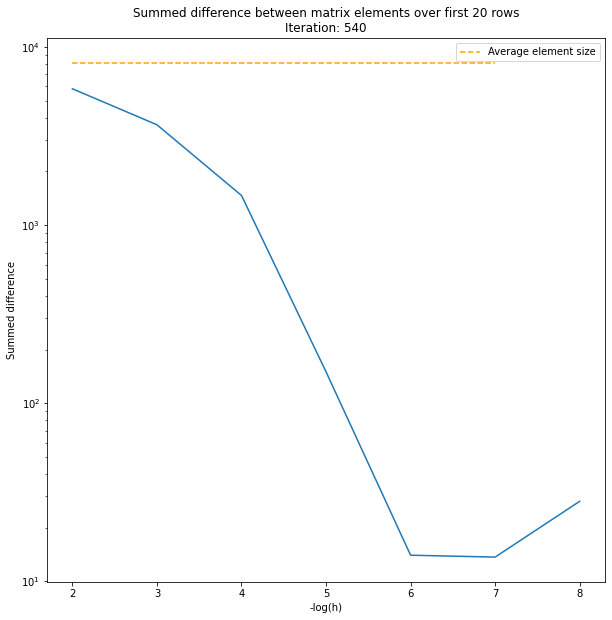

Sum = 8130.4833984375
Number of elements = 300
Average =  27.101612091064453
Summed Ratio = 0.0016836980357766151
Max Ratio = 5.0308514


In [134]:
#Create a plot of the difference between matrices as a function of pertubation parameter.

xs = [2,3,4,5,6,7,8]
difference_list = [difference_2, difference_3, difference_4, difference_5, difference_6, difference_7, difference_8]
plt.figure(figsize=[10,10])
plt.plot(xs, difference_list, label='Differences')
plt.xticks([2,3,4,5,6,7,8])
plt.yscale('log')
plt.xlabel('-log(h)')
plt.ylabel('Summed difference')
plt.title('Summed difference between matrix elements over first 20 rows\nIteration: ' + str(itr))
plt.plot()

elements_sum = 0
elements = []

for j in range(num):
  i = random_i[j]
  k = random_k[j]
  elements_sum += torch.abs(library_hessian[i,k])
  elements.append(library_hessian[i,k])

plt.plot([2, 7], [elements_sum, elements_sum], '--', color = 'Orange', label='Average Element Size')
plt.legend()
plt.show()

#Print useful information.
mofd_ratios = []
for i in range(len(elements)):
  ratio = (differences_7[i])/(elements[i])
  mofd_ratios.append(ratio)

print('Sum = ' + str(elements_sum.item()))
print('Number of elements = ' + str(num))
print('Average =  ' + str((elements_sum/num).item()))
print('Summed Ratio = ' + str((difference_7/elements_sum).item()))
print('Max Ratio = ' + str(np.max(mofd_ratios)))

In [133]:
#MOFD Hessian.
if args.extra_dim == 0:
  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/node/models/model_'
                  + str(itr) + '.pt')
else:
  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/anode('
                    +str(args.extra_dim)+')/models/model_'+ str(itr) + '.pt')
  
double_model = model.double()
optimizer = optim.Adam(model.parameters())
optimizer.zero_grad()

#Prepare loss for MOFD.
pred_y = model(z0.double()).double()
base_loss_func = nn.CrossEntropyLoss()
target = torch.zeros(len(zN))
for i in range(len(zN)):
  if zN[i]==0:
    target[i] = 0
  else:
    target[i] = 1
target = target.long()
base_loss = base_loss_func(pred_y, target).double()

#Prepare shape information for MOFD.
shapes = []
for param in model.parameters():
  shapes.append(param.shape)

#Create vector of parameters.
param_tensors = double_model.parameters()
params_vec = torch.tensor([]).to(device)
for param in param_tensors:
  vec = torch.reshape(param, (-1,)).to(device)
  params_vec = torch.cat((params_vec, vec))

print(library_hessian[0,:10])
w = len(params_vec)                  #Range of elements to examine.
print('Getting MOFD Hessian for iteration ' + str(itr) + '...')
counter = w*(w+1)/2
mofd_hessian = torch.zeros((w,w)).double()
for i in range(w):
  for k in range(w):

    #Only calculate for k >= i, in the same way as get_mofd_hessian_element().
    #Failing to do so yields UnboundLocalError since local variable, grad2, is referenced before assignment.
    if k >= i:                     
      element = get_mofd_hessian_element(params_vec, shapes, base_loss, i, k, h=1e-7)
      mofd_hessian[i,k] = element.item()    #.item() is required to prevent RAM growth.
      mofd_hessian[k,i] = element.item()
      counter -= 1
      print("\rIterations remaining: " + str(int(counter)) + ', Element: ' + str(element.item()), end = '')
print('')

torch.save(mofd_hessian, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name + '/node'
                        + '/hessian_data/' + str(itr) + '_mofd_hessian_7.pt')

tensor([ 0.7949,  0.6623, -9.2038, -2.5792, -5.2095, -2.9453,  1.1416,  0.6824,
        14.3879,  3.6964])
Getting MOFD Hessian for iteration 540...
Iterations remaining: 0, Element: -1.0842021724855046e-05


In [ ]:
#Calculate library Hessian data for every model during training.
library_hessian_data = []
for itr in range(0, 605, 5):
  model = torch.load('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' + exp_name 
                     + '/anode(1)/models/model_' + str(itr) + '.pt')
  model = model.to(device)

  print('Obtaining library hessian for iteration ' + str(itr) + '...')
  library_start = time.time()
  library_hessian = get_library_hessian(model)                       #get hessian with library functions   
  library_end = time.time()
  print("Time taken was " + str(round(library_end-library_start,2)) + "s.")

  library_hessian_data.append((itr, library_end-library_start, library_hessian))

#Save this information.
torch.save(library_hessian_data, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/nested_spheres/cross_entropy/' 
                + exp_name + '/anode(1)/hessian_data/library_hessian_data.pt')


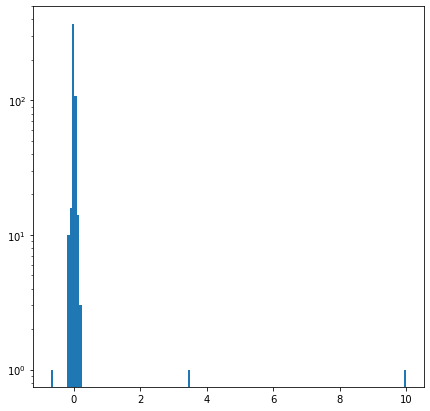

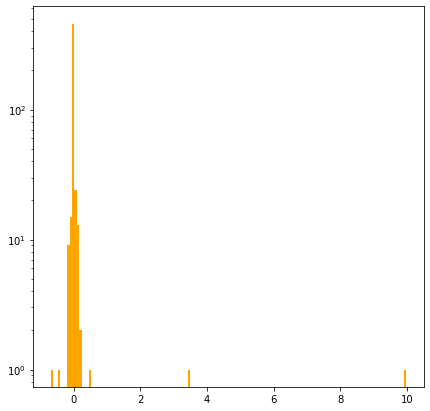

In [141]:
e, v = torch.symeig(mofd_hessian)
plt.figure(figsize=[7,7])
plt.hist(e[:-1], bins=150)
plt.yscale('log')
plt.show()

e, v = torch.symeig(library_hessian)
plt.figure(figsize=[7,7])
plt.hist(e[:-1], bins=150, color = 'Orange')
plt.yscale('log')
plt.show()